Scopo degli algoritmi di Computer Vision da usare nel nostro progetto:


    Input: Immagine 

         --> Detector [Immagine] = {Array di keypoints} 

         --> Descriptor [{Array di keypoints}] = {Matrice di features}

(Ogni Keypoint viene descritto da un numero/tipo di features differenti che dipende dall'algoritmo usato. SIFT per esempio sta per "Scale Invariant Feature Transform" e si base su features preservabili da trasformazioni spaziali ([roto-traslazioni / restizioni-espansioni])

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline

In [2]:
# Define the path to the two folders
folder_1_path = "dataset/byteplot/malicious/"
folder_2_path = "dataset/byteplot/benign/benign/"
folder_3_path = "dataset/byteplot/benign/benign_edu/"

# Read the images in each folder and store them in a list
images_1 = [cv2.imread(os.path.join(folder_1_path, image_file), cv2.IMREAD_GRAYSCALE) \
            for image_file in os.listdir(folder_1_path)]
images_2 = [cv2.imread(os.path.join(folder_2_path, image_file), cv2.IMREAD_GRAYSCALE) \
            for image_file in os.listdir(folder_2_path)]
images_3 = [cv2.imread(os.path.join(folder_3_path, image_file), cv2.IMREAD_GRAYSCALE) \
            for image_file in os.listdir(folder_3_path)]

In [3]:
import random

random.seed(42)

random.shuffle(images_1)

max_len_benign = len(images_2)+len(images_3)

images_1 = images_1[:max_len_benign]

In [4]:
# Label each image with the respective label (1 for total_des_trainfolder_1, 2 for folder_2)
labels_1 = [0 for _ in range(len(images_1))]
labels_2 = [1 for _ in range(len(images_2)+len(images_3))]

# Combine the images and labels into a single dataset
images = images_1 + images_2 + images_3
labels = labels_1 + labels_2

X = images
y = labels

In [5]:
print(len(X))
print(len(y))

5936
5936


In [6]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Implementazione SIFT/ORB descriptors. Partendo dal file path, generiamo di nuovo il bytre plot, ma questa volta evidenziamo i keypoints.

In [7]:
# Define detector object
nfeatures = 41
detector = cv2.ORB_create(nfeatures)

a=[]
b=[]
c=[]
d=[]

for image in X_train:
    query_kps, query_des = detector.detectAndCompute(image, None)
    a.append(query_kps)
    b.append(query_des)

for image in X_test:
    query_kps, query_des = detector.detectAndCompute(image, None)
    c.append(query_kps)
    d.append(query_des)

In [8]:
total_kps_train= a
total_des_train= b
total_kps_test= c
total_des_test= d

In [9]:
null_indexes_train = []

for i,e in enumerate(total_des_train):
    if e is None:
        null_indexes_train.append(i)

In [10]:
total_des_train = np.delete(total_des_train, null_indexes_train) 
y_train = np.delete(y_train,null_indexes_train)

In [11]:
total_des_train = total_des_train.tolist()
y_train = y_train.tolist()

In [12]:
null_indexes_test = []

for i,e in enumerate(total_des_test):
    if e is None:
        null_indexes_test.append(i)

In [13]:
total_des_test = np.delete(total_des_test, null_indexes_test) 
y_test = np.delete(y_test,null_indexes_test)

In [14]:
total_des_test = total_des_test.tolist()
y_test = y_test.tolist()

In [15]:
max0 = 0
for des in total_des_train:
    if des is not None:
        if des.shape[0] > max0:
            max0 = des.shape[0]

max1=0
for des in total_des_test:
    if des is not None:
        if des.shape[0] > max1:
            max1 = des.shape[0]
    
if max1 > max0:
    max0=max1

In [16]:
i = 0
for des in total_des_train:
    padding_to_add = max0 - des.shape[0]
    if padding_to_add != 0:
        pad_list = []
        for k in range(32):
            pad_list.append(0)
        for j in range(padding_to_add):
            total_des_train[i] = np.append(total_des_train[i], pad_list)
        total_des_train[i] = np.array(total_des_train[i]).reshape(max0,32)
    i += 1

i = 0
for des in total_des_test:
    padding_to_add = max0 - des.shape[0]
    if padding_to_add != 0:
        pad_list = []
        for k in range(32):
            pad_list.append(0)
        for j in range(padding_to_add):
            total_des_test[i] = np.append(total_des_test[i], pad_list)
        total_des_test[i] = np.array(total_des_test[i]).reshape(max0,32)
    i += 1

In [17]:
i = 0
for des in total_des_train:
    total_des_train[i] = np.hstack(des)
    i += 1

i = 0
for des in total_des_test:
    total_des_test[i] = np.hstack(des)
    i += 1

gridsearch (using accuracy as a metric)

Mean accuracy:  0.6798604187437687
Standard deviation:  0.02729182707864323


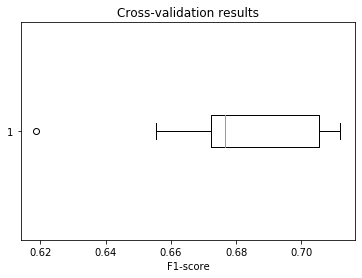

In [18]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Define the parameters to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 4, 8],
    'min_samples_leaf': [1, 2, 4]
}

# Create an instance of the RandomForestClassifier
clf = RandomForestClassifier(random_state=42)

# Create an instance of GridSearchCV
grid_search = GridSearchCV(clf, param_grid, cv=10)

# Fit the grid search to the data
grid_search.fit(total_des_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Get the best classifier
best_clf = grid_search.best_estimator_

# Use cross_val_score to evaluate the classifier with the best parameters
scores = cross_val_score(best_clf, total_des_test, y_test, cv=10)

# Print the mean and standard deviation of the scores
print("Mean accuracy: ", scores.mean())
print("Standard deviation: ", scores.std())

# Plot the results as a box plot
plt.boxplot(scores, vert=False)
plt.xlabel("F1-score")
plt.title("Cross-validation results")
plt.show()

If everything goes fine, I plotted the wrong x label, as this is the "accuracy" scoring. Needed editing in post production in case